In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import yaml
import sys

from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

sys.path.append("../../../../utils")
from absolute_path_builder import AbsolutePathBuilder

In [2]:
plt.rcParams['figure.figsize']  = (3.33, 5.5)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3

In [3]:
df_inputation_schema = pd.read_csv(
    AbsolutePathBuilder.get_path(
        "00_inputation_schema",
        filepaths="../../../../config/filepaths.yaml"
    )
)
df_data_desc = pd.read_csv(
    AbsolutePathBuilder.get_path(
        "00_youtube_data_description",
        filepaths="../../../../config/filepaths.yaml"
    )
)

bins = np.linspace(0, 1, num=20)

---

### Toxicity Score Cumulative Distribution Function (CDF)

100%|███████████████████████████████████████████████████████████████████| 6/6 [00:18<00:00,  3.02s/it]


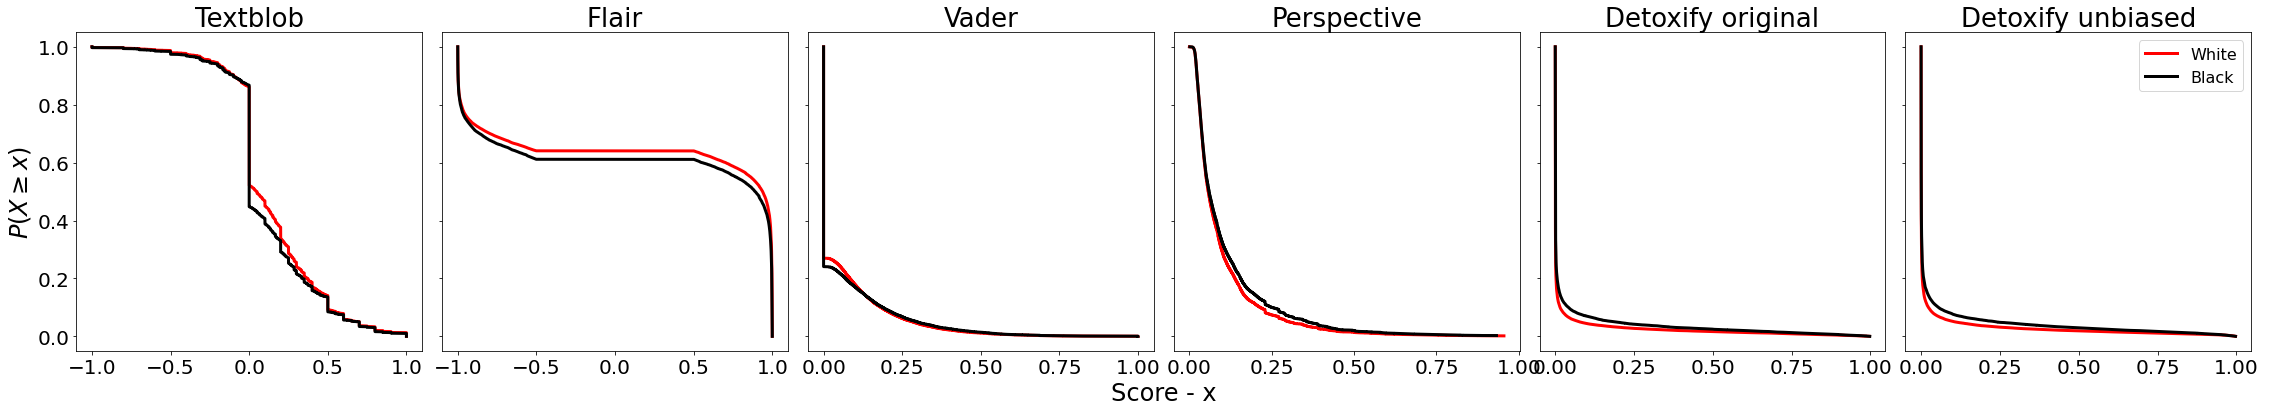

In [4]:
group_color = {
    "White": "red",
    "Black": "black",
}

fig, axs = plt.subplots(1, 6, figsize=(32, 6), sharey=True)

for i, SCORE_NAME in enumerate(
    tqdm(
        [
            "textblob",
            "flair",
            "vader",
            "perspective",
            "detoxify_original",
            "detoxify_unbiased",
        ]
    )
):
#     axins = zoomed_inset_axes(axs[i], 5, loc=1)
        
    # Transforms the groups into White or Black
    df_data_desc["group"] = df_data_desc.group.apply(lambda s: s.split()[0])
    for group in group_color.keys():
        group_urls = df_data_desc[df_data_desc.group == group]    
        filenames = [row["url"].split("v=")[1].split("&")[0] for _, row in group_urls.iterrows()]

        dfs = []
        count = 0
        for filename in filenames:
            try:
                input_path = AbsolutePathBuilder.get_path(
                    "04_youtube_scored",
                    filepaths="../../../../config/filepaths.yaml"
                )
                df = pd.read_csv(os.path.join(os.path.join(input_path, filename)))
                dfs.append(df)
            except:
                count += 1

        df = pd.concat(dfs)
        del dfs

        df = df[~df.has_swearing]

        ecdf = ECDF(df[f"{SCORE_NAME}_score"])
        axs[i].plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])

        # Add a subaxis with the same traces
        # axins.plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])
        
    axs[i].set_title(f"{SCORE_NAME.replace('_', ' ').capitalize()}", fontsize=26)
#     axs[i].set_xlim(-0.01, 1)
    
    # The slice of the axis that will be zoomed in
    # axins.set_xlim(0.92, 1)
    # axins.set_ylim(-0.01, 0.05)

    # Draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    # mark_inset(axs[i], axins, loc1=3, loc2=4, fc="none", ec="0.5")
    
#     plt.xticks(visible=False)
#     plt.yticks(visible=False)

plt.legend()
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Score - x", fontsize=24)
plt.ylabel(r"$P(X \geq x)$", fontsize=24)
plt.tight_layout(pad=0)
plt.savefig(
    os.path.join(
        AbsolutePathBuilder.get_path(
            "youtube_imgs",
            filepaths="../../../../config/filepaths.yaml"
        ),
        f"youtube_icdfs_appendix_wo_swear.pdf"
    )
)
plt.show()

---

### Two-Sample Kolmogorov-Smirnov's Test

In [5]:
for i, SCORE_NAME in enumerate(
    tqdm(
        [
            "perspective",
            "detoxify_original",
            "detoxify_unbiased",
            "vader",
            "flair",
            "textblob",
        ]
    )
):
    dfs = []
    for group in df_data_desc["group"].unique():
        group_urls = df_data_desc[df_data_desc.group == group]    
        filenames = [row["url"].split("v=")[1].split("&")[0] for _, row in group_urls.iterrows()]

        df_group = []
        count = 0
        for filename in filenames:
            try:
                input_path = AbsolutePathBuilder.get_path(
                    "04_youtube_scored",
                    filepaths="../../../../config/filepaths.yaml"
                )
                df = pd.read_csv(os.path.join(os.path.join(input_path, filename)))

                df_group.append(df)
            except:
                count += 1

        print(f"Group: `{group}` had {count} reading problems")

        df_group = pd.concat(df_group)
        df_group["group"] = group

        dfs.append(df_group)

    df = pd.concat(dfs)
    del dfs, df_group

    ks_all = []
    groups = df.group.unique()
    for first_group in groups:
        ks_one_vs_all = []
        for second_group in groups:
            statistic, p_value = ks_2samp(
                df[df.group == first_group][f"{SCORE_NAME}_score"],
                df[df.group == second_group][f"{SCORE_NAME}_score"]
            )

            ks_one_vs_all.append(
                f"{np.abs(np.round(statistic*100, 3))} ({np.round(p_value*100, 3)})"
            )
        ks_all.append(ks_one_vs_all)
        
    ks_all = pd.DataFrame(ks_all, columns=groups, index=groups)
    print(ks_all)

  0%|                                                                           | 0/6 [00:00<?, ?it/s]

Group: `White` had 1 reading problems


 17%|███████████▏                                                       | 1/6 [00:02<00:12,  2.53s/it]

Group: `Black` had 0 reading problems
             White        Black
White  0.0 (100.0)  3.787 (0.0)
Black  3.787 (0.0)  0.0 (100.0)
Group: `White` had 1 reading problems


 33%|██████████████████████▎                                            | 2/6 [00:04<00:09,  2.49s/it]

Group: `Black` had 0 reading problems
             White        Black
White  0.0 (100.0)  5.129 (0.0)
Black  5.129 (0.0)  0.0 (100.0)
Group: `White` had 1 reading problems


 50%|█████████████████████████████████▌                                 | 3/6 [00:07<00:07,  2.50s/it]

Group: `Black` had 0 reading problems
             White        Black
White  0.0 (100.0)  7.355 (0.0)
Black  7.355 (0.0)  0.0 (100.0)
Group: `White` had 1 reading problems


 67%|████████████████████████████████████████████▋                      | 4/6 [00:10<00:05,  2.51s/it]

Group: `Black` had 0 reading problems
             White        Black
White  0.0 (100.0)  2.921 (0.0)
Black  2.921 (0.0)  0.0 (100.0)
Group: `White` had 1 reading problems


 83%|███████████████████████████████████████████████████████▊           | 5/6 [00:12<00:02,  2.55s/it]

Group: `Black` had 0 reading problems
             White        Black
White  0.0 (100.0)   9.34 (0.0)
Black   9.34 (0.0)  0.0 (100.0)
Group: `White` had 1 reading problems


100%|███████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.54s/it]

Group: `Black` had 0 reading problems
             White        Black
White  0.0 (100.0)  7.711 (0.0)
Black  7.711 (0.0)  0.0 (100.0)
